 <div style="text-align:center;">
   <span style="color:white; font-size:larger; font-weight:bold;">Modélisation</span><br><br>
</div>

# Introduction

## Références et équations de base de la relation d'Okun

Dans cette partie, nous allons proposer une modélisation permettant de vérifier empiriquement la loi d'Okun, à partir des bases de données établies dans la partie "Préparation_données.ipynb".

La loi d'Okun, indique que : "chaque fois que le PIB chute d'un certain pourcentage, par rapport au produit potentiel, le taux de chômage augmente d'environ un point de pourcentage. Ainsi, lorsque le PIB réel diminue, le taux de chômage augmente." (Mankiw, 2003)

Pour cette modélisation, on s'inspire des travaux suivants : 

- [1]. Traoré, D. L., Diakite, S., & Mariko, O. (2021). Croissance et chômage au Mali : Vérification empirique de la loi d'Okun. Revue Malienne de Science et de Technologie, Série C : Sciences Humaines et Sociales, 02(25), Page. ISSN 1987-1031. CNRST, Bamako, Mali.

- [2]. Aassif, Z. L'extraction de la tendance cycle. Haut-Commissariat au Plan, Direction de la comptabilité nationale. 

- [3]. Belaidi, N. (2022, 28 mars). Validation croisée en Machine Learning. Consulté le  12 décembre 2023. URL : https://blent.ai/blog/a/validation-croisee-machine-learning.


Le travail [1] nous présente deux équations de base de la relation d'Okun, la version en "différences premières" et la "version gap".

- Version en "différences premières" : 
$$\Delta u = C + \beta\Delta \text{pib} + \epsilon$$

- "Version gap" : 
$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$

avec $u$ le taux de chômage, $u^*$ le taux de chômage naturel, $\text{pib}^*$ le PIB potentiel et c, $\beta$ et $\epsilon$  des constantes à déterminer grâce à la modélisation. 

## Equation et outils utilisés dans notre modélisation

Pour la modélisation, nous allons utiliser la version "gap", qui relie le taux de chômage et le PIB de la manière suivante : 

$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$

Pour extraire la tendance à long terme du taux de chômage et du PIB (c'est-à-dire, le taux de chômage naturel et le PIB potentiel), à partir de la base de données, nous allons utiliser le filtre de Hodrick-Prescott. Ce filtre est introduit dans [2], et permet de décomposer une série selon sa tendance à long terme et son cycle (fluctuations autour de la tendance) à plus court terme.

Par ailleurs, pour prendre en compte la dynamique temporelle de nos données, nous allons utiliser le modèle ARDL (Auto Regressive Distributed Lag), introduit dans [2].

## Les différentes étapes de notre modélisation


Pour effectuer notre modélisation sur les données obtenues suite au traitement, nous allons tout d'abord regrouper les pays présents selon différents critères, grâce à la technique du clustering. 
Nous sélectionnerons un pays de manière aléatoire au sein de chaque groupe afin de vérifier la loi d'Okun (ou alors nous vérifierons la loi d'Okun pour chaque groupe après agrégation).

(Par ailleurs, nous allons utiliser une méthode de validation croisée afin de valider notre modèle. Nous allons tout d'abord établir les paramètres du modèle grâce au jeu d'entrainement reprenant les données de 1994 à 2016 ; puis nous vérifierons la précision du modèle grâce au jeu de test reprenant les données de 2017 à 2023.)


# I- Extraction de la tendance à long terme du taux de chômage et du PIB

## Importation des bases de données

In [2]:
import declarations as d 

In [3]:
# Bases de données relatives au PIB et au taux de chômage

data_semestre = d.pd.read_csv('bases/donnees_semestrielles.csv', encoding='latin-1')
data_moyenne = d.pd.read_csv('bases/donnees_moyennees.csv', encoding = 'latin-1')

In [ ]:
# Base de données relative aux variables considérées pour le clustering

## Extraction de la tendance à long terme pour le PIB (gdp)

In [4]:
data_semestre.head(2)

,Dates,ARG_gdp,ARG_rate,AUS_gdp,AUS_rate,AUT_gdp,AUT_rate,BEL_gdp,BEL_rate,BGR_gdp,...,TUR_gdp,TUR_rate,"Taiwan, China_gdp","Taiwan, China_rate",URY_gdp,URY_rate,USA_gdp,USA_rate,ZAF_gdp,ZAF_rate
0,1994-01,0.635635,9.724381,0.501645,10.580050,0.906967,6.672157,0.920006,9.518617,0.815213,...,0.006777,10.480357,0.972158,1.400000,0.735524,9.929305,0.650468,6.6,0.224378,26.474568
1,1994-04,0.644039,9.724381,0.502208,10.269157,0.906967,6.582263,0.920006,9.728535,0.815213,...,0.009421,10.480357,0.971386,1.633333,0.735524,9.929305,0.653595,6.5,0.225938,26.474568


## Extraction de la tendance à long terme pour le taux de chômage (rate)

In [5]:
# Extraire toutes les colonnes avec le suffixe "_rate" ainsi que la colonne des dates
columns_rate = ['Dates'] + [col for col in data_semestre.columns if col.endswith('_rate')] 
df_rates = data_semestre[columns_rate]
df_rates.set_index('Dates', inplace = True)

df_rates.head(2)

,ARG_rate,AUS_rate,AUT_rate,BEL_rate,BGR_rate,CAN_rate,CHE_rate,COL_rate,CYP_rate,Czech Republic_rate,...,RUS_rate,SGP_rate,SVN_rate,SWE_rate,THA_rate,TUR_rate,"Taiwan, China_rate",URY_rate,USA_rate,ZAF_rate
Dates,,,,,,,,,,,,,,,,,,,,,
1994-01,9.724381,10.580050,6.672157,9.518617,15.860000,11.400000,4.847199,11.808516,7.71193,4.2,...,6.024640,1.700000,15.100000,11.26787,1.380426,10.480357,1.400000,9.929305,6.6,26.474568
1994-04,9.724381,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,11.808516,7.71193,4.2,...,6.574419,1.666667,14.966667,10.86699,1.380426,10.480357,1.633333,9.929305,6.5,26.474568


In [6]:
# Extraire toutes les colonnes avec le suffixe "_gdp" ainsi que la colonne des dates
columns_gdp = ['Dates'] + [col for col in data_semestre.columns if col.endswith('_gdp')] 
df_gdp = data_semestre[columns_gdp]
df_gdp.set_index('Dates', inplace = True)

df_gdp.head(2)

,ARG_gdp,AUS_gdp,AUT_gdp,BEL_gdp,BGR_gdp,CAN_gdp,CHE_gdp,COL_gdp,CYP_gdp,Czech Republic_gdp,...,RUS_gdp,SGP_gdp,SVN_gdp,SWE_gdp,THA_gdp,TUR_gdp,"Taiwan, China_gdp",URY_gdp,USA_gdp,ZAF_gdp
Dates,,,,,,,,,,,,,,,,,,,,,
1994-01,0.635635,0.501645,0.906967,0.920006,0.815213,0.680429,0.907331,0.909903,0.915292,0.933408,...,0.443597,0.806523,0.914395,0.585296,0.767809,0.006777,0.972158,0.735524,0.650468,0.224378
1994-04,0.644039,0.502208,0.906967,0.920006,0.815213,0.680180,0.909250,0.909903,0.915292,0.933408,...,0.443597,0.812181,0.914395,0.587775,0.778599,0.009421,0.971386,0.735524,0.653595,0.225938


In [22]:
import statsmodels.tsa.filters.hp_filter as smf
import statsmodels.tsa.ardl as sma
import statsmodels.api as sm

## Exemple de la Belgique

### Extraction de la tendance de la série

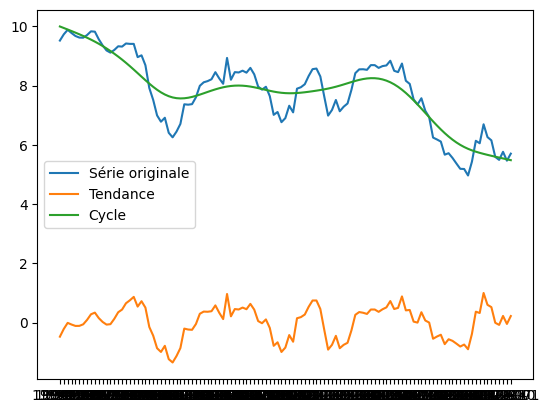

In [8]:
# Extraction de la tendance long terme du taux de chômage
x = df_rates['BEL_rate']

# Appliquer le filtre de Hodrick-Prescott
tendance_x, cycle_x = smf.hpfilter(x, lamb=1600)

# Afficher les résultats
d.plt.plot(x, label='Série originale')
d.plt.plot(tendance_x, label='Tendance')
d.plt.plot(cycle_x, label='Cycle')
d.plt.legend()
d.plt.show()

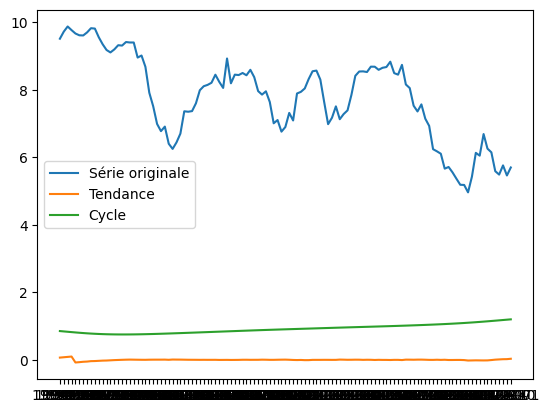

In [9]:
# Extraction de la tendance long terme du PIB
y = df_gdp['BEL_gdp']

# Appliquer le filtre de Hodrick-Prescott
tendance_y, cycle_y = smf.hpfilter(y, lamb=1600)

# Afficher les résultats
d.plt.plot(x, label='Série originale')
d.plt.plot(tendance_y, label='Tendance')
d.plt.plot(cycle_y, label='Cycle')
d.plt.legend()
d.plt.show()

In [10]:
nouveau_x = x - tendance_x
nouveau_y = y - tendance_y

In [11]:
dfx = nouveau_x.reset_index().rename(columns={'index': 'Dates'})
dfx = dfx.rename(columns = {0:'rates'})

In [12]:
dfy = nouveau_y.reset_index().rename(columns={'index': 'Dates'})
dfy = dfy.rename(columns = {0 :'gdp'})

In [13]:
data_Belgique = d.pd.merge(dfx, dfy, on='Dates', how='inner')
data_Belgique.head(2)

,Dates,rates,gdp
0,1994-01,9.994411,0.853213
1,1994-04,9.943249,0.842851


### Régression linéaire simple avec la méthode OLS : 

La régression linéaire simple considère chaque observation comme indépendante des autres, ce qui signifie qu'elle ne modélise pas l'autocorrélation ou la dépendance temporelle potentielle entre les observations successives. 

In [14]:
# S'assurer que la colonne Dates est au format datetime
data_Belgique['Dates'] = d.pd.to_datetime(data_Belgique['Dates'])

# Ajouter une constante à vos données pour inclure l'intercept dans le modèle
data_Belgique['const'] = 1

# Spécifier les variables indépendantes (X) et dépendante (y)
X = data_Belgique[['const', 'rates']]
y = data_Belgique['gdp']

# Créer et ajuster le modèle de régression linéaire
model = sm.OLS(y, X)
results = model.fit()

# Afficher les résultats du modèle
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     182.0
Date:                Sun, 24 Dec 2023   Prob (F-statistic):           1.92e-25
Time:                        11:38:56   Log-Likelihood:                 133.62
No. Observations:                 117   AIC:                            -263.2
Df Residuals:                     115   BIC:                            -257.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6204      0.053     30.801      0.0

### Modèle ARIMA (AutoRegressive Integrated Moving Average)

Ici, on considère un modèle de séries temporelles, qui capture la dépendance temporelle et modélise la dynamique temporelle des données.

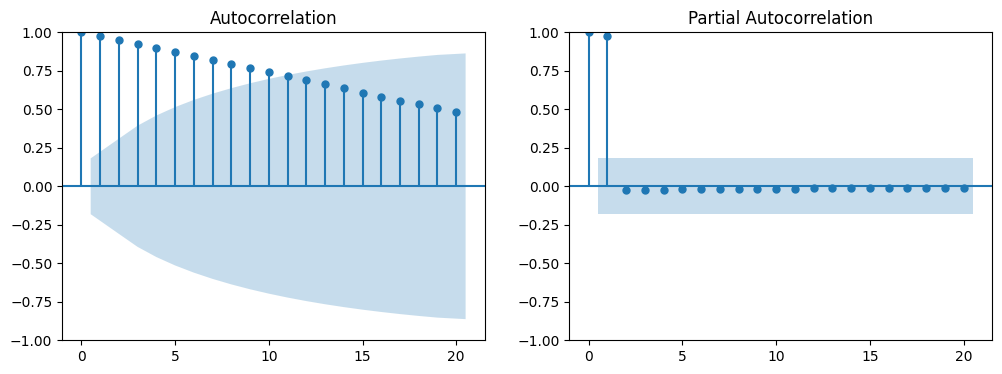

In [15]:
# AACF (AutoCorrelation Function)
# PACF (Partial AutoCorrelation Function)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Tracez l'ACF et PACF
fig, ax = d.plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data_Belgique['gdp'], lags=20, ax=ax[0])
plot_pacf(data_Belgique['gdp'], lags=20, ax=ax[1])
d.plt.show()


In [31]:
# Créer et ajuster le modèle ARIMA
model = sm.tsa.ARIMA(data_Belgique['gdp'], order=(2, 2, 11))  # Spécifier l'ordre du modèle ARIMA
results = model.fit()

# Afficher les résultats du modèle
print(results.summary())


c:\Users\Amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    gdp   No. Observations:                  117
Model:                ARIMA(2, 2, 11)   Log Likelihood                -853.229
Date:                Sun, 24 Dec 2023   AIC                           1734.458
Time:                        11:55:26   BIC                           1772.887
Sample:                    01-01-1994   HQIC                          1750.056
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8952      0.001   1878.041      0.000       1.893       1.897
ar.L2         -0.9126      0.000  -7107.061      0.000      -0.913      -0.912
ma.L1          1.0254      0.000   6046.492      0.0

### Modèle ARDL

In [39]:
# Spécifiez les paramètres du modèle ARDL
endog_variable = data_Belgique['gdp']
lags_endog = 2  # Nombre de retards pour la variable endogène
exog_variables = data_Belgique['rates']
lags_exog = [1, 2]  # Nombre de retards pour les variables exogènes
trend = 'c'  # 'c' pour une constante, 'ct' pour une constante et une tendance linéaire, ou None pour aucun

# Créez le modèle ARDL
model_ardl = sma.ARDL(endog_variable, lags=lags_endog, exog=exog_variables, order=lags_exog, trend=trend)

# Ajustez le modèle
results = model_ardl.fit()

# Affichez les résultats du modèle
print(results.summary())


c:\Users\Amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


IndexError: tuple index out of range

In [40]:
# Spécifiez les retards que vous souhaitez inclure
lags = 2

# Créez des colonnes de lags pour rates
for i in range(1, lags + 1):
    data_Belgique[f'rates_lag{i}'] = data_Belgique['rates'].shift(i)

# Spécifiez les variables indépendantes (X) et dépendante (y)
X = data_Belgique[['const', 'rates_lag1', 'rates_lag2']]
y = data_Belgique['gdp']

# Éliminez les lignes avec des valeurs manquantes introduites par les lags
data_Belgique = data_Belgique.dropna()

# Créez et ajustez le modèle de régression linéaire avec lags
model = sm.OLS(y, X)
results = model.fit()

# Affichez les résultats du modèle
print(results.summary())


MissingDataError: exog contains inf or nans

# II- Clustering : regroupement des pays selon des critères de développement

# III- Vérification de la loi pour un pays tiré de manière i.i.d. dans chaque groupe